$$\textbf{Machine Learning. Tarea 6: Redes Recurrentes}$$
$$\textit{Y. Sarahi García Gozález}$$

Implemente un modelo de red recurrente que reconozca entre las seis actividades en el problema establecido en https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones 

Los datos corresponds a los acelerometros y gyroscopes en celulares preprocesados para efectos de  eliminar ruido y normalización.

Tiene libertad para elegir el tipo de red recurrente y la arquitectura (numero de capas, bidireccional o no, dimension de los datos ocultos, etc).

Como guia vea https://www.kaggle.com/code/fahadmehfoooz/human-activity-recognition-with-neural-networks donde se presenta un MLP en Torch.

<font size=4 color='mediumslateblue'>  

$\textit{Librerías}$

In [1]:

import numpy as np
import tensorflow as tf
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
import random
import warnings
warnings.filterwarnings('ignore')

In [53]:
print("Tarea realizada en MacOs. \nLas versiones de las librerías y de python utilizadas fueron:\n")
from platform import python_version
print("Python version:", python_version())
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print(f"Scikit-Learn {sk.__version__}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
# print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE") 


Tarea realizada en MacOs. 
Las versiones de las librerías y de python utilizadas fueron:

Python version: 3.11.5
NumPy version: 1.23.5
Pandas version: 2.1.4
Scikit-Learn 1.3.0
Tensor Flow Version: 2.16.1
Keras Version: 3.3.3
GPU is available


In [3]:
len(tf.config.list_physical_devices('GPU'))

1

<font size=4 color='mediumslateblue'>  

$\textit{Lectura, analisis exploratorio de los datos}$

In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(f'Shape of train data is: {train_data.shape}\nShape of test data is: {test_data.shape}')

Shape of train data is: (7352, 563)
Shape of test data is: (2947, 563)


In [5]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [6]:
train_data['Activity'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

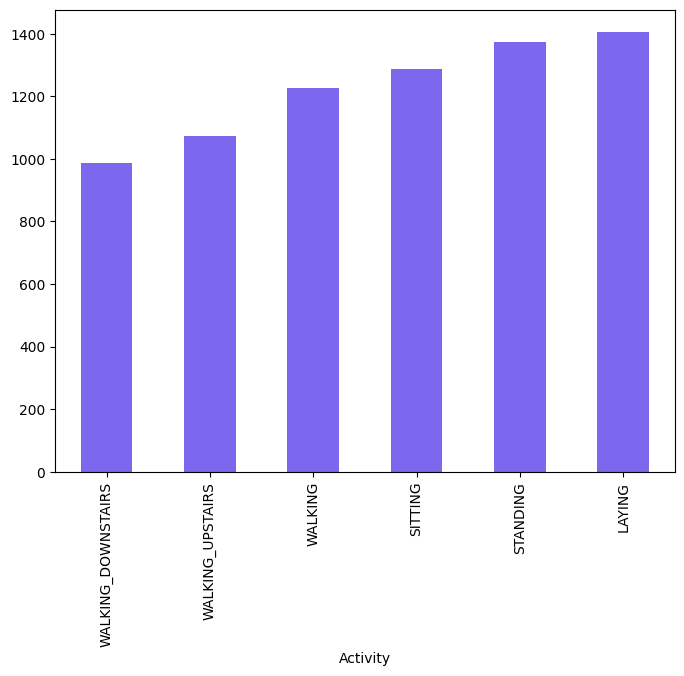

In [7]:
plt.figure(figsize=(8, 6))
train_data['Activity'].value_counts().sort_values().plot(kind = 'bar', color = 'mediumslateblue')
plt.show()

In [8]:
#separamos en features y labels
x_train, y_train = train_data.iloc[:, :-2], train_data.iloc[:, -1:]
x_test, y_test = test_data.iloc[:, :-2], test_data.iloc[:, -1:]
x_train.shape, y_train.shape


((7352, 561), (7352, 1))

In [9]:
x_test, y_test = test_data.iloc[:, :-2], test_data.iloc[:, -1:]
x_test.shape, y_test.shape

((2947, 561), (2947, 1))

In [10]:
#escalmos los datos
scaling_data = MinMaxScaler()
x_train = scaling_data.fit_transform(x_train)
x_test = scaling_data.transform(x_test)

In [11]:
#codificamos las etiquetsa etiquetas 
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [12]:
#Convertimos nuestris datos a forma de secuencias
def create_sequences(X, y, time_steps=100):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)
#tomemos secuencias de longitud fija (100 timestep)
time_steps = 100
X_train_seq, y_train_seq = create_sequences(x_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(x_test, y_test, time_steps)

Basandome en el ejemplo proporcionado, que es un modelo simple, comencé con una arquitectura simple de una capas LSTM pero el val_loss se quedaba al rededor de 0.5 y el val_accuracy al rededor de 0.87, mientras que el ejemplo alcanza:


EJEMPLO: loss: 0.2109 - accuracy: 0.9276 - val_loss: 0.2082 - val_accuracy: 0.9226


De modo que agregué una capa LSTM más, y la capa densa para la etapa de clasificación, sin embargo no mejoró mucho:

accuracy: 0.8586 - loss: 0.3972 - val_accuracy: 0.8757 - val_loss: 0.3403

Probé con más capas pero tarda mucho en entrenar y se sobreentrena. Finalmente intenté con una arquitectura bidireccional y mejor bastante. 

<font size=4 color='mediumslateblue'>  

$\textit{RNN}$

In [13]:
input_shape=(time_steps, X_train_seq.shape[2])


RNN = models.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
    layers.Dropout(0.3),
    layers.LSTM(units=64),
    layers.Dropout(0.3),
    layers.Dense(units=6,activation='softmax'),
],name="RNN")

RNN.summary()

2024-05-20 18:18:39.807949: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-20 18:18:39.808008: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-20 18:18:39.808024: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-20 18:18:39.808579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-20 18:18:39.809126: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │       160,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,670 (756.52 KB)

 Trainable params: 193,670 (756.52 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#Parametros para el modelo RNN
num_epochs = 30
lr = 0.0001
batch_size = 64

In [15]:
# Ruta para guardar el mejor modelo
checkpoint_filepath = 'best_model_UNI.keras'

#callback para el mejor modelo 
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#Callback para detener el entrenamiento si no mejora el val_loss después de 3 épocas
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

#usamos adam
optimizer = Adam(learning_rate=lr)

#Compilamos el modelo
RNN.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo con ambos callbacks
history = RNN.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test_seq, y_test_seq), callbacks=[checkpoint, early_stopping])

Epoch 1/30


2024-05-20 18:19:06.473988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3925 - loss: 1.5114
Epoch 1: val_loss improved from inf to 0.71833, saving model to best_model_UNI.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.3939 - loss: 1.5091 - val_accuracy: 0.7738 - val_loss: 0.7183
Epoch 2/30
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7833 - loss: 0.6701
Epoch 2: val_loss improved from 0.71833 to 0.47299, saving model to best_model_UNI.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7840 - loss: 0.6681 - val_accuracy: 0.8328 - val_loss: 0.4730
Epoch 3/30
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8410 - loss: 0.4605
Epoch 3: val_loss improved from 0.47299 to 0.40235, saving model to best_model_UNI.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8410 - loss: 0.4602 - val_accuracy: 0.8451 - val_loss: 0.4023
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8586 - loss: 0.3973
Epoch 4: val_loss improved from 0.40235 to 0

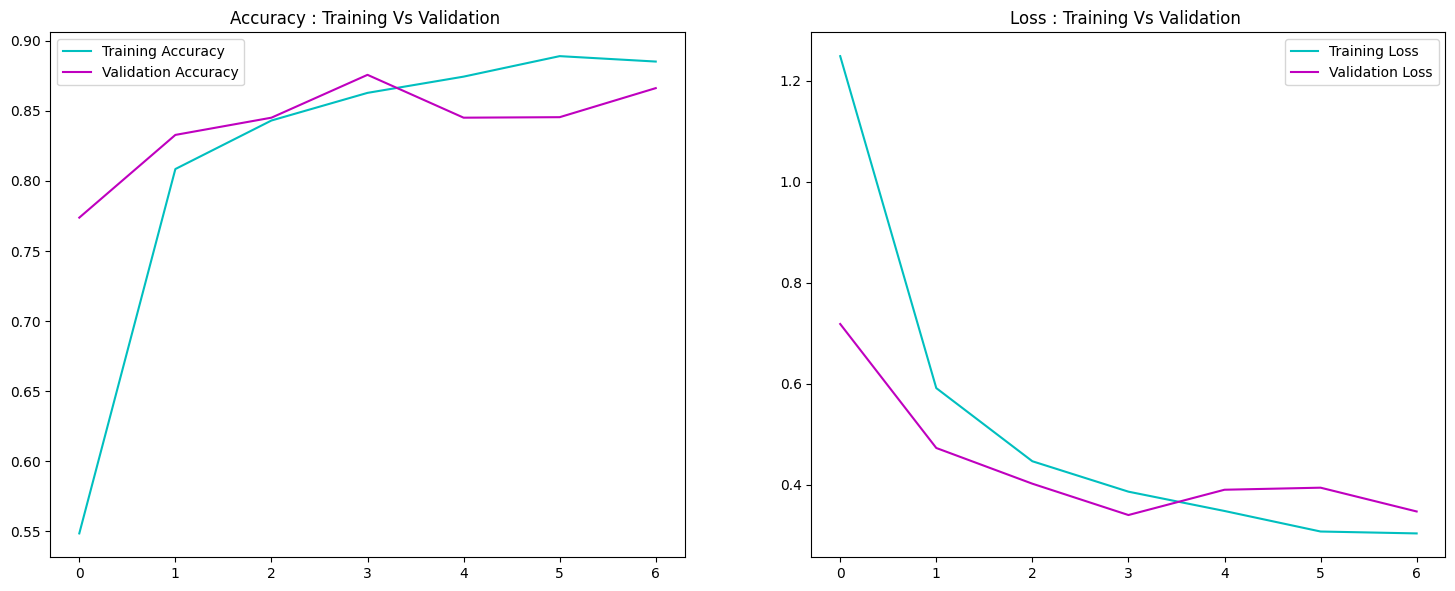

In [16]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

n=range(len(accuracy))
plt.figure(figsize=(18, 15))

plt.subplot(2, 2, 1)
plt.plot(n, accuracy,"c" ,label='Training Accuracy')
plt.plot(n, validation_accuracy,"m", label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')

plt.subplot(2, 2, 2)
plt.plot(n, loss, "c" ,label='Training Loss')
plt.plot(n, validation_loss, "m",label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()

<font size=4 color='mediumslateblue'>  

$\textit{RNN bidireccional}$

In [43]:
input_shape=(time_steps, X_train_seq.shape[2])
bi_RNN = models.Sequential([
    layers.Bidirectional(layers.LSTM(units=64, return_sequences=True), input_shape=(time_steps, X_train_seq.shape[2])),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.LSTM(units=64)),
    layers.Dropout(0.3),
    layers.Dense(units=6,activation='softmax'),
],name="bi_RNN")

bi_RNN.summary()

Model: "bi_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_16                │ (None, 100, 128)       │       320,512 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,102 (1.60 MB)

 Trainable params: 420,102 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
#Parametros para el modelo bi-RNN
num_epochs_bi = 30
lr_bi = 0.0001
batch_size_bi = 16

In [45]:
# Ruta para guardar el mejor modelo
checkpoint_filepath = 'best_model_BI.keras'

#callback para el mejor modelo 
checkpoint_bi = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#Callback para detener el entrenamiento si no mejora el val_loss después de 3 épocas
early_stopping_bi = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

#usamos adam
optimizer_bi = Adam(learning_rate=lr)

#Compilamos el modelo
bi_RNN.compile(optimizer=optimizer_bi, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [46]:
# Entrenamos el modelo con ambos callbacks (mejor modelo y early stopping)
history_bi = bi_RNN.fit(X_train_seq, y_train_seq, batch_size=batch_size_bi, epochs=num_epochs_bi, validation_data=(X_test_seq, y_test_seq), callbacks=[checkpoint_bi, early_stopping_bi])

Epoch 1/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6204 - loss: 1.0492
Epoch 1: val_loss improved from inf to 0.35842, saving model to best_model_BI.keras
454/454 ━━━━━━━━━━━━━━━━━━━━ 68s 141ms/step - accuracy: 0.6207 - loss: 1.0484 - val_accuracy: 0.8648 - val_loss: 0.3584
Epoch 2/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8744 - loss: 0.3411
Epoch 2: val_loss improved from 0.35842 to 0.28477, saving model to best_model_BI.keras
454/454 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - accuracy: 0.8744 - loss: 0.3410 - val_accuracy: 0.8967 - val_loss: 0.2848
Epoch 3/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9110 - loss: 0.2544
Epoch 3: val_loss improved from 0.28477 to 0.28316, saving model to best_model_BI.keras
454/454 ━━━━━━━━━━━━━━━━━━━━ 58s 127ms/step - accuracy: 0.9109 - loss: 0.2544 - val_accuracy: 0.8904 - val_loss: 0.2832
Epoch 4/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9198 - loss: 0.2314
Epoch 4: val_loss improved f

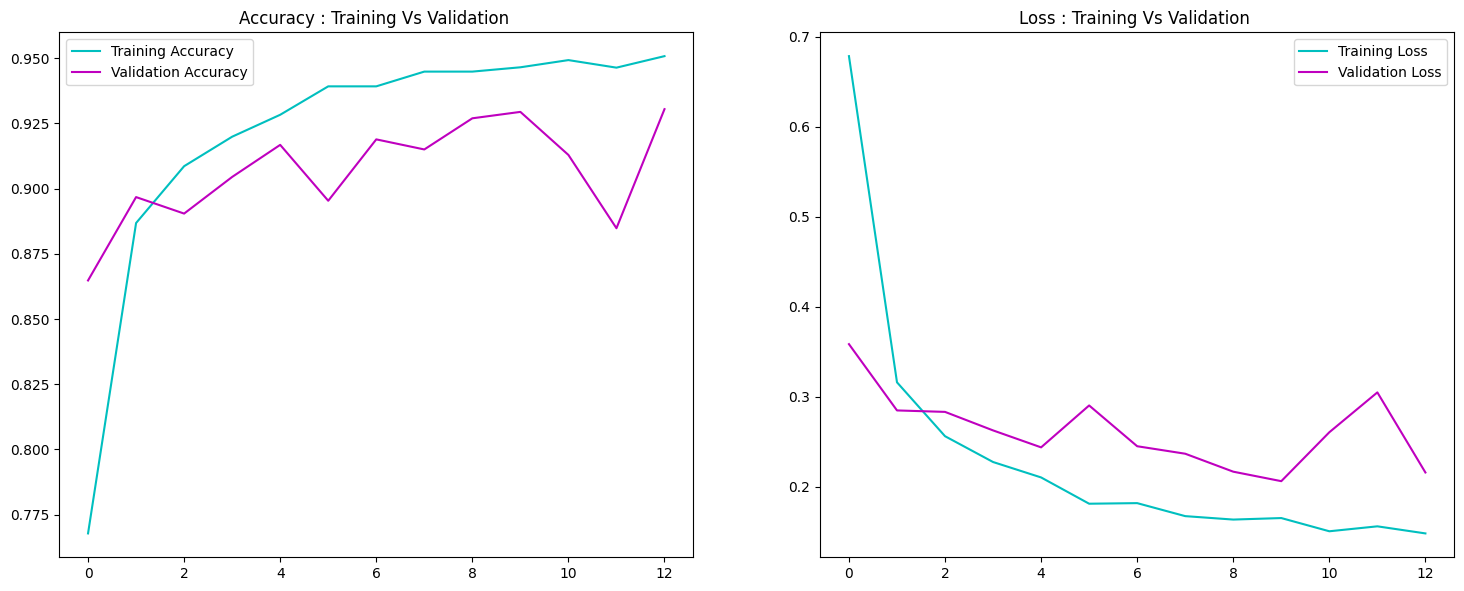

In [47]:
accuracy_bi = history_bi.history['accuracy']
loss_bi = history_bi.history['loss']
validation_loss_bi = history_bi.history['val_loss']
validation_accuracy_bi = history_bi.history['val_accuracy']

n_bi=range(len(accuracy_bi))
plt.figure(figsize=(18, 15))

plt.subplot(2, 2, 1)
plt.plot(n_bi, accuracy_bi,"c" ,label='Training Accuracy')
plt.plot(n_bi, validation_accuracy_bi,"m", label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')

plt.subplot(2, 2, 2)
plt.plot(n_bi, loss_bi, "c" ,label='Training Loss')
plt.plot(n_bi, validation_loss_bi, "m",label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()

<font size=4 color='mediumslateblue'>  

$\textit{Predicción}$


In [23]:
#predicción
y_pred_bi= bi_RNN.predict(X_test_seq)

y_pred= RNN.predict(X_test_seq)

89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [50]:
for j in range(10):
    i=random.randint(0,len(y_pred))
    y_true = le.inverse_transform([int(y_test_seq[i])])
    prediction = le.inverse_transform([y_pred[i].argmax()])
    prediction_bi = le.inverse_transform([y_pred_bi[i].argmax()])

    print("Sample :", i)
    print("True label:", y_true)
    print("Prediction RNN bidireccional:", prediction_bi)
    print("Prediction RNN:", prediction)
    print("------------------")

Sample : 773
True label: ['WALKING_DOWNSTAIRS']
Prediction RNN bidireccional: ['WALKING_DOWNSTAIRS']
Prediction RNN: ['WALKING_DOWNSTAIRS']
------------------
Sample : 2480
True label: ['STANDING']
Prediction RNN bidireccional: ['STANDING']
Prediction RNN: ['STANDING']
------------------
Sample : 1562
True label: ['WALKING_UPSTAIRS']
Prediction RNN bidireccional: ['WALKING_DOWNSTAIRS']
Prediction RNN: ['WALKING_DOWNSTAIRS']
------------------
Sample : 10
True label: ['WALKING_DOWNSTAIRS']
Prediction RNN bidireccional: ['WALKING']
Prediction RNN: ['WALKING_DOWNSTAIRS']
------------------
Sample : 824
True label: ['STANDING']
Prediction RNN bidireccional: ['STANDING']
Prediction RNN: ['STANDING']
------------------
Sample : 2762
True label: ['WALKING']
Prediction RNN bidireccional: ['WALKING']
Prediction RNN: ['WALKING']
------------------
Sample : 971
True label: ['STANDING']
Prediction RNN bidireccional: ['STANDING']
Prediction RNN: ['STANDING']
------------------
Sample : 2837
True la

Ejemplo: 

    accuracy: 0.9276 - loss: 0.2109 - val_accuracy: 0.9226 - val_loss: 0.2082

RNN:
    
    accuracy: 0.8586 - loss: 0.3972 - val_accuracy: 0.8757 - val_loss: 0.3403

 
RNN Bidireccional:
    
    accuracy: 0.9473 - loss: 0.1617 - val_accuracy: 0.9294 - val_loss: 0.2062
    

Por lo que alcanzamos resultados muy parecidos (un poco mejores) y el mejor modelo se alcanzó a las 10 épocas igual que el modelo base del ejemplo, sin embarg el número de parámetros entrenables para la RNN bidireccional fue de 420,102 mientras que el modelo del ejemplo sólo son 36,358

In [51]:
model_ejemplo = models.Sequential()
model_ejemplo.add(layers.Dense(units=64,kernel_initializer='normal',activation='sigmoid',input_dim=x_train.shape[1]))
model_ejemplo.add(layers.Dropout(0.2))
model_ejemplo.add(layers.Dense(units=6,kernel_initializer='normal',activation='softmax'))
model_ejemplo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 64)             │        35,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,358 (142.02 KB)

 Trainable params: 36,358 (142.02 KB)

 Non-trainable params: 0 (0.00 B)

Nota: comparé con el $\textit{modelo base}$ del ejemplo porque después, en las pruebas de la sección $\textbf{Hypertuning The Model}$ alcanzan mejor accuracy pero el loss es de al rededor de 0.5 y el val_loss de 0.8.